In [1]:
# adapted version of 
# https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline

In [2]:
# Load the data
train_df = pd.read_csv('../data/train.csv', header=0)
test_df = pd.read_csv('../data/test.csv', header=0)

In [3]:
train_df['Intact'], train_df['Sex'] = train_df\
    .SexuponOutcome.str.split(' ').str
train_df['Intact'] = train_df['Intact']\
    .replace('Unknown', np.nan)
train_df['Intact'] = train_df['Intact']\
    .replace('Spayed', 'Neutered')

test_df['Intact'], test_df['Sex'] = test_df\
    .SexuponOutcome.str.split(' ').str
test_df['Intact'] = test_df['Intact']\
    .replace('Unknown', np.nan)

def calc_age_in_days(df):
    factor = {'year': 365, 'month': 31, 'week': 7, 'day': 1}
    result = []
    for age in df.AgeuponOutcome:
        if str(age) != 'nan':
            value, unit = age.split(' ')
            days = \
                int(value) * factor[unit.replace('s', '')] 
            # ignore year[s], month[s], ...
            result.append(days)
        else:
            result.append(np.nan)
    df['AgeuponOutcomeInDays'] = result
    return df

def calc_age_in_years(df):
    result = []
    for age in df.AgeuponOutcomeInDays:
        if str(age) != 'nan':
            years = int(age / 365)
            result.append(years)
        else:
            result.append(np.nan)
    df['AgeuponOutcomeInYears'] = result
    return df

train_df = calc_age_in_days(train_df)
train_df = calc_age_in_years(train_df)
test_df = calc_age_in_days(test_df)
test_df = calc_age_in_years(test_df)

Split `SexuponOutcome` into `Intact` and `Sex`

In [4]:
# We'll impute missing values using the median for numeric
# columns and the most common value for string columns.
# This is based on some nice code by 'sveitser' at
# http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
                               if X[c].dtype == np.dtype('O')
                               else X[c].median() for c in X],
                              index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

feature_columns_to_use = ['AnimalType', 'SexuponOutcome', 'Breed',
                          'AgeuponOutcomeInDays']  
# <- best features so far

nonnumeric_columns = feature_columns_to_use

# Join the features from train and test together before 
# imputing missing values, in case their distribution is 
# slightly different
# Do we really wanna do this? S/b said this is bad practice 
# for some reason
big_X = train_df[feature_columns_to_use].append(
    test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)
big_X_imputed[5:10]

,AnimalType,SexuponOutcome,Breed,AgeuponOutcomeInDays
5,Dog,Intact Female,Cairn Terrier/Chihuahua Shorthair,31.0
6,Cat,Intact Male,Domestic Shorthair Mix,21.0
7,Cat,Unknown,Domestic Shorthair Mix,21.0
8,Dog,Spayed Female,American Pit Bull Terrier Mix,155.0
9,Dog,Spayed Female,Cairn Terrier,365.0


Fill in missing fields:
* `mean` if column is numeric
* `most common value` if not numeric

In [5]:
# See 
# http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
# for more details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

# Prepare the inputs for the model
train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
test_X = big_X_imputed[train_df.shape[0]::].as_matrix()
train_df.OutcomeType = le.fit_transform(train_df.OutcomeType)
train_y = train_df['OutcomeType']

## Do the actual learning

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_X, train_y, test_size=0.01, random_state=10)

`train_test_split` is a shorthand to randomly split a training set into train/test data for cross validation. 

* `test_size`: sets the percentage of data used for the test set.
* `random_state`: is used to get reproducible randomness

In [7]:
# cross validation training set
xgmat = xgb.DMatrix(X_train, label=y_train)
# cross validation test set
xgmat_valid = xgb.DMatrix(X_valid, label=y_valid)
# the original test set from kaggle
xgmat_test = xgb.DMatrix(test_X)

transforms our generated cross validation data to a format readable by `xgboost`

## Parameters
Some information about parameter tweaking: [click](http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### objective
Set against which loss function the algorithm should minimize. What we need: Multiclass with probabilities. So we choose `multi:softprob`. This in return needs a parameter `num_class` which indicates the number of differenct classes. In our case thats the number of distinct values for cloumn `OutcomeType`

### Others
* `eval_metric`: set to `mlogloss`, that is the one kaggle uses
* `max_delta_setp`: set to number > 0 to fight imbalanced data sets (http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)

In [8]:
param = {
    'objective': 'multi:softprob',
    # should be 5
    'num_class': train_df.OutcomeType.nunique(),
    # feature weight shrinkrage: lower -> reduce complexity
    'eta': 0.35,
    # loss reduction needed to split a leaf and add another 
    # layer: higher -> reduces complexity
    'gamma': 0.00,
    # maximum depth of a tree: higher -> increase complexity
    'max_depth': 8,
    # minimum number of instances in a leaf: higher -> less complexity
    # 'min_child_weight': 12,  
    # in logregression a higher value might help with imbalanced classes
    'max_delta_step': 1,
    # randomly select instances from train set to 
    # build trees: lower -> less overfitting
    'subsample': 0.5,
    # subsample colums: lower -> less overfitting
    'colsample_bytree': 0.5,
    # regularization weight: higher -> less complex
    'alpha': 0,
    # fight unbalanced classes: sum(negative cases) / sum(positive cases)
    'scale_pos_weight': 0,  
    'eval_metric' : 'mlogloss',
    'silent': 1
}

In [9]:
num_round=3000
watchlist = [(xgmat, 'train'), (xgmat_valid, 'eval')]
gbm = xgb.train(param, xgmat, num_round, watchlist, early_stopping_rounds=100)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-mlogloss:1.418455	eval-mlogloss:1.429267
[1]	train-mlogloss:1.246294	eval-mlogloss:1.262411
[2]	train-mlogloss:1.164008	eval-mlogloss:1.181612
[3]	train-mlogloss:1.094919	eval-mlogloss:1.116524
[4]	train-mlogloss:1.040706	eval-mlogloss:1.064858
[5]	train-mlogloss:1.002848	eval-mlogloss:1.032077
[6]	train-mlogloss:0.964524	eval-mlogloss:0.999383
[7]	train-mlogloss:0.941076	eval-mlogloss:0.981549
[8]	train-mlogloss:0.923167	eval-mlogloss:0.964063
[9]	train-mlogloss:0.906709	eval-mlogloss:0.949384
[10]	train-mlogloss:0.891419	eval-mlogloss:0.937201
[11]	train-mlogloss:0.878990	eval-mlogloss:0.925890
[12]	train-mlogloss:0.867721	eval-mlogloss:0.920318
[13]	train-mlogloss:0.862581	eval-mlogloss:0.916676
[14]	train-mlogloss:0.859031	eval-mlogloss:0.917146
[15]	train-mlogloss:0.851402	eval-mlogloss:0.912880
[16]	train-mlogloss:0.846427	eval-mlogloss:0.906657
[17]	train-mlogloss:0.841754	eval-mlogloss:0.901629
[18]	train-mlo

We don't just simply learn a model but we observe how the precision evolves [more info](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#training)
* `early_stopping_rounds`: will stop training if the precision did not improve in the set number of rounds
* `watchlist`: contains the parameters to watch while learning

__*train() only returns the last model, not necessarily the best one!*__  see [here](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#prediction)

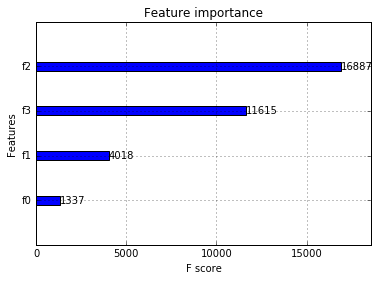

In [10]:
xgb.plot_importance(gbm)

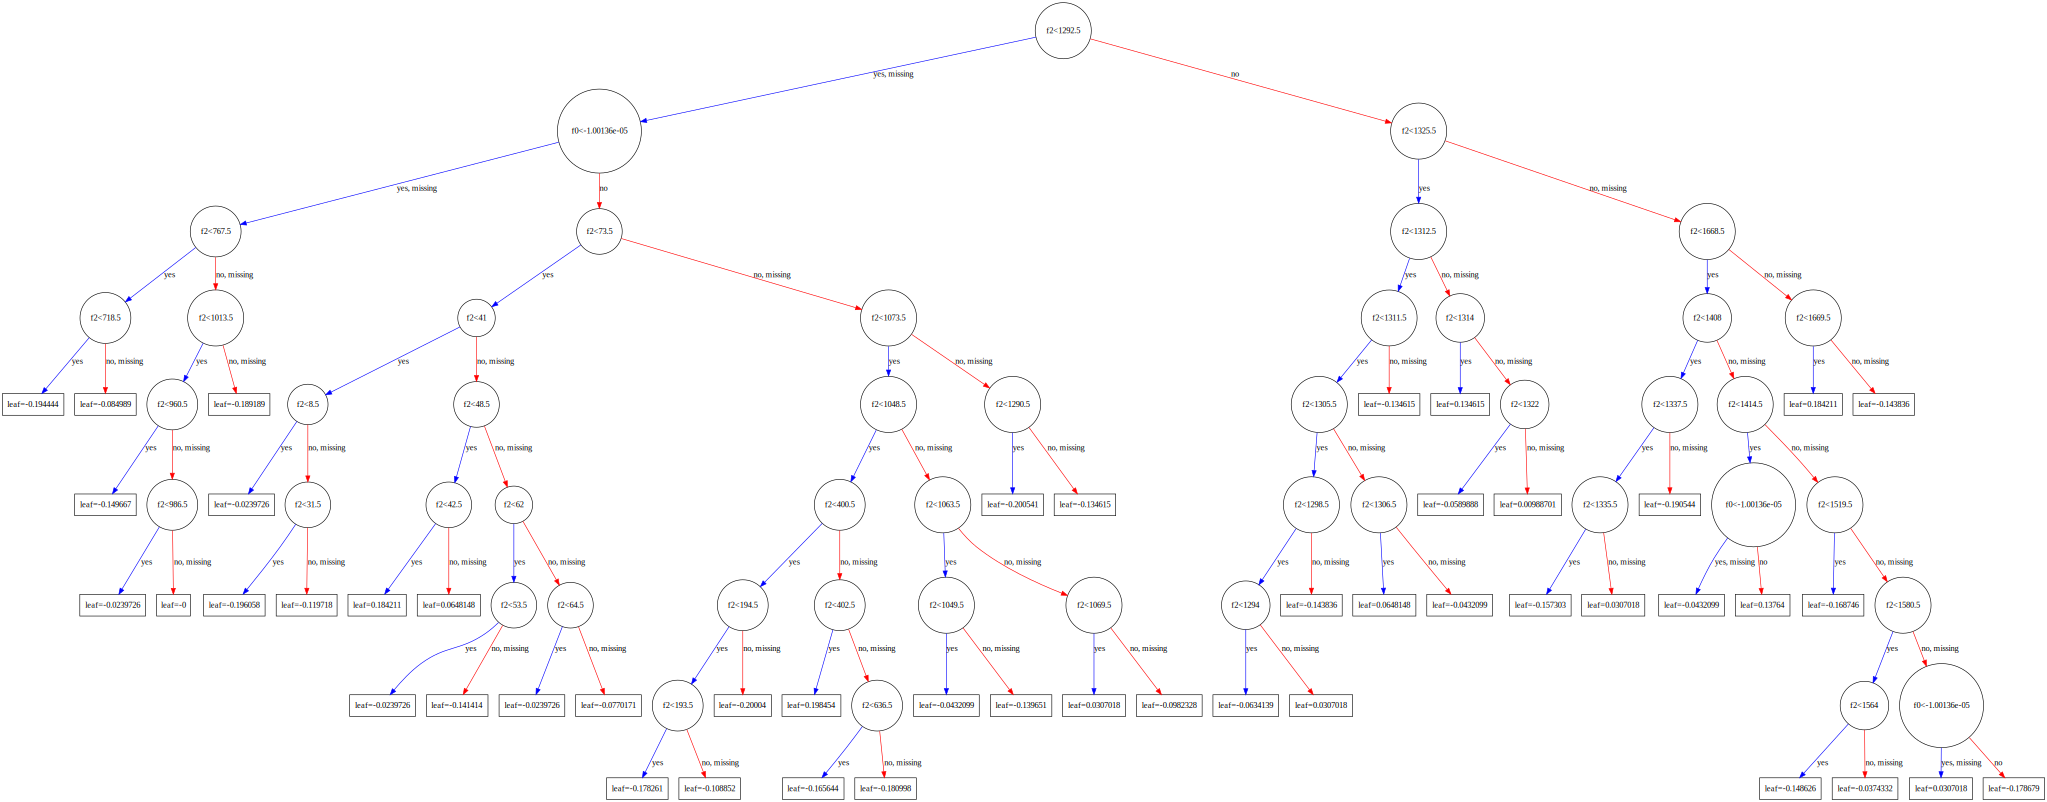

In [11]:
# needs graphviz: 'sudo apt-get install graphviz' and 'pip3 install graphviz'
xgb.to_graphviz(gbm, num_trees=2)

## Predict and save as Kaggel

In [12]:
predictions = gbm.predict(xgmat_test, ntree_limit=gbm.best_ntree_limit)

predictions

/Users/simon/Documents/projects/python/kaggle_env/lib/python3.5/site-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


array([[  3.17921415e-02,   3.07041989e-03,   2.48723123e-02,
          7.63411820e-02,   8.63923907e-01],
       [  5.55560529e-01,   2.37099058e-03,   2.65514664e-02,
          3.05334777e-01,   1.10182248e-01],
       [  3.73905450e-01,   2.46217521e-03,   2.94291191e-02,
          1.01120405e-01,   4.93082881e-01],
       ..., 
       [  2.32541729e-02,   5.23404079e-03,   8.62579197e-02,
          1.56510361e-02,   8.69602799e-01],
       [  3.45851958e-01,   7.48497609e-04,   4.49268445e-02,
          4.35288340e-01,   1.73184395e-01],
       [  2.13605557e-02,   1.92810467e-03,   6.81205615e-02,
          5.79314411e-01,   3.29276323e-01]], dtype=float32)

In [13]:
# to kaggle format
submission_df = pd.DataFrame(predictions)
submission_df = pd.concat([test_df.ID, submission_df], axis=1)
submission_df.ID = submission_df.ID.astype(int)
submission_df.set_index('ID', inplace=True)
# get the string labels back
submission_df.columns = le.inverse_transform(
    sorted(train_df.OutcomeType.unique()))
submission_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
ID,,,,,
1,0.031792,0.003070,0.024872,0.076341,0.863924
2,0.555561,0.002371,0.026551,0.305335,0.110182
3,0.373905,0.002462,0.029429,0.101120,0.493083
4,0.047490,0.001542,0.035549,0.032619,0.882800
5,0.501308,0.002677,0.014746,0.265933,0.215336


In [14]:
submission_df.to_csv('submission.csv')
len(submission_df)

11456